Importing the nesscary header files

In [22]:
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

Reading the input files

In [23]:
train = pd.read_csv('../inputs/train.csv')
test = pd.read_csv('../inputs/Realtimedatabasetest.csv')
subm = pd.read_csv('../inputs/realtimedatabasesamplesubmit.csv')

Viewing the begining of the training data set

In [24]:
train.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

Viewing a few of the comments

In [25]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

The length of the comments varies a lot.

In [26]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

Histogram to view the size of the comments. X axis represents length of the comments and y axis represents number of comments.

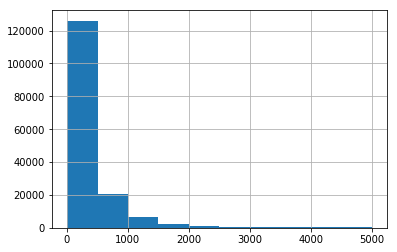

In [27]:
lens.hist();

Create a list of all the labels to predict, and also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

In [28]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

toxic   severe_toxic        obscene         threat  \
count  159571.000000  159571.000000  159571.000000  159571.000000   
mean        0.095844       0.009996       0.052948       0.002996   
std         0.294379       0.099477       0.223931       0.054650   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              insult  identity_hate           none  
count  159571.000000  159571.000000  159571.000000  
mean        0.049364       0.008805       0.898321  
std         0.216627       0.093420       0.302226  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       1.000000  
50%         0.000000       0.000000       1.000000  
75%         0.000000       0.000000       1.000000  
max         1.000000       1.000000       1.000000

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [29]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

# Bag of words representation

Using regular expressions to tokenize the words in the dataset. Split based on punctuations by replacing punctuations with a white space and split the string.

In [30]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s):return re_tok.sub(r' \1 ', s).split()

TfidVectorizer is used to create the tf-idf sparse matrix. The matrix (mxn) where m is the number of comments in the training dataset and n is the unigrams or bigrams created out of the sentences 

In [31]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

fit() : used for generating learning model parameters from training data
transform() : parameters generated from fit() method,applied upon model to generate transformed data set.
fit_transform() : combination of fit() and transform() api on same data set

In [32]:
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

In [33]:
print(test_term_doc.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
trn_term_doc

<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
	with 17775104 stored elements in Compressed Sparse Row format>

#Navie Bayes basic implementation

The pr function used to isolate the values from the tf-ifd matrix which correspond to the value of y_i (0|1). This is done by comparing the y_i value to the y.value for every category and using the conditional statement to index into the tfifd matrix 

In [35]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    print((p+1) / ((y==y_i).sum()+1))
    return (p+1) / ((y==y_i).sum()+1)

In [36]:
x = trn_term_doc
test_x = test_term_doc

The mdl meathod is initally takes the natural log of the value returned by pr to calculate r (log-count-ratio) using r we normalize the tfifd values and fit a logistic regression model for one dependent at a time

In [37]:
def get_mdl(y):
    y = y.values
    print(y.size)
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r ,y

Create the predictions matrix to hold the predicted values.Also find the training accuracy for every category 

In [38]:
preds = np.zeros((len(test), len(label_cols)))
preds1 = np.zeros((len(train), len(label_cols)))
for i, j in enumerate(label_cols):
    print('fit', j)
    print(train[j])
    m,r,y= get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]
    preds1[:,i] = m.predict_proba(x.multiply(r))[:,1]
    y_true = y
    y_scores = [i[0] for i in preds1]
    print("training accuracy ",roc_auc_score(y_true, y_scores))
    print(preds)

fit toxic
0         0
1         0
2         0
3         0
4         0
5         0
6         1
7         0
8         0
9         0
10        0
11        0
12        1
13        0
14        0
15        0
16        1
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
159541    1
159542    0
159543    0
159544    0
159545    0
159546    1
159547    0
159548    0
159549    0
159550    0
159551    0
159552    0
159553    0
159554    1
159555    0
159556    0
159557    0
159558    0
159559    0
159560    0
159561    0
159562    0
159563    0
159564    0
159565    0
159566    0
159567    0
159568    0
159569    0
159570    0
Name: toxic, Length: 159571, dtype: int64
159571
[[2.87181235e-02 1.94243215e-02 1.42388213e-03 ... 6.53808434e-05
  6.53808434e-05 6.53808434e-05]]
[[8.87919121e-03 2.39226500e-03 1.14547050e-03 ... 8.57783057e-06
  2.80898416e-05 2.80898416e-05]]
training 

[[9.75317142e-03 3.12627948e-03 1.16844668e-03 ... 8.15842473e-06
  2.67164123e-05 2.67164123e-05]]
training accuracy  0.9853067980767005
[[1.34005553e-02 5.74342971e-04 3.32851997e-03 1.85127079e-04
  4.13725894e-03 0.00000000e+00]
 [4.57319149e-03 4.91846380e-04 2.57854072e-03 1.34149953e-04
  1.12239265e-02 0.00000000e+00]
 [9.99997530e-01 1.88840016e-01 9.74865950e-01 7.48975934e-04
  9.99773080e-01 0.00000000e+00]
 [9.92206380e-01 2.15967939e-02 5.85048223e-02 9.99707699e-01
  2.79161009e-02 0.00000000e+00]
 [1.00000000e+00 8.87118602e-01 1.00000000e+00 2.23926941e-04
  9.99948586e-01 0.00000000e+00]
 [6.06739246e-03 5.36329702e-04 3.22734864e-03 1.31599486e-04
  2.91569349e-03 0.00000000e+00]
 [9.43823489e-03 4.07742315e-04 2.07357880e-03 1.25946946e-04
  5.61683081e-03 0.00000000e+00]
 [7.01743701e-02 4.23803381e-03 1.43353429e-02 3.15489287e-04
  1.54596544e-02 0.00000000e+00]
 [1.83257902e-02 4.21112188e-04 4.14968255e-03 1.11317205e-04
  6.21114695e-03 0.00000000e+00]
 [1.175

Create the submissions file

In [40]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('../inputs/submision.csv', index=False)